# Sp prediction with GCN

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.0 MB/s 
     |████████████████████████████████| 376 kB 48.9 MB/s 
     |████████████████████████████████| 45 kB 4.0 MB/s 


In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Loading the facebook

In [4]:
import gdown
!mkdir datasets
# Download edgelist in txt format (extracted from mtx)
!gdown https://drive.google.com/uc?id=1YYSMQbRkGClW7nEg9XJ7eORnGiCnat0w -O datasets/facebook_edges.txt
# Download pretrained node2vec embeddings in emd format
!gdown https://drive.google.com/uc?id=13UGK9JZs-sKlG_urgt6wj773zyU8NrtE -O datasets/Facebook.emd

!gdown https://drive.google.com/uc?id=1LiadUU7jar9jiz_c__55Wx4QcJTSUeFR -O ./datasets/train.txt
!gdown https://drive.google.com/uc?id=1OsUiEGlkRjsrkV2ml9_UpbXAxnCCx3D3 -O ./datasets/test.txt

Downloading...
From: https://drive.google.com/uc?id=1YYSMQbRkGClW7nEg9XJ7eORnGiCnat0w
To: /content/datasets/facebook_edges.txt
100% 854k/854k [00:00<00:00, 54.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=13UGK9JZs-sKlG_urgt6wj773zyU8NrtE
To: /content/datasets/Facebook.emd
5.91MB [00:00, 27.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LiadUU7jar9jiz_c__55Wx4QcJTSUeFR
To: /content/datasets/train.txt
11.9MB [00:00, 55.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OsUiEGlkRjsrkV2ml9_UpbXAxnCCx3D3
To: /content/datasets/test.txt
100% 1.31M/1.31M [00:00<00:00, 84.3MB/s]


In [5]:
import tensorflow as tf
import numpy as np

In [6]:
emd = open("./datasets/Facebook.emd", 'r')
word2vec=[None] * 4039
for line in emd:
  a=line.strip('\n').split(' ')
  if len(a)>2:
    word2vec[int(a[0])]=list(map(float, a[1:]))
  #print(a[0])


In [7]:
import pandas as pd
import numpy as np

edges = pd.read_csv('datasets/facebook_edges.txt',delimiter=" ")
random_features=(np.random.rand(4039,1024)*2)-1
#G=sg.StellarGraph(random_features, edges)
G=sg.StellarGraph(np.array(word2vec), edges)

In [8]:
np.array(word2vec).shape

(4039, 128)

In [9]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 4039, Edges: 88234

 Node types:
  default: [4039]
    Features: float64 vector, length 128
    Edge types: default-default->default

 Edge types:
    default-default->default: [88234]
        Weights: all 1 (default)
        Features: none


In [10]:
train_set = []
y_train = []

f_train = open("./datasets/train.txt", 'r')
for line in f_train:
  a=line.strip('\n').split(' ')
  train_set.append([int(a[0]),int(a[1])]) 
  y_train.append(int(a[2]))
f_train.close()

train_set=np.array(train_set)
y_train=np.array(y_train)

In [11]:
test_set = []
y_test = []

f_test = open("./datasets/test.txt", 'r')
for line in f_test:
  a=line.strip('\n').split(' ')
  test_set.append([int(a[0]),int(a[1])]) 
  y_test.append(int(a[2]))
f_test.close()

test_set=np.array(test_set)
y_test=np.array(y_test)

In [12]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [13]:
shuffle_in_unison(train_set, y_train)
shuffle_in_unison(test_set, y_test)

## Creating the GCN link model

In [14]:
train_gen = FullBatchLinkGenerator(G, method="gcn")
train_flow = train_gen.flow(train_set, y_train)

Using GCN (local pooling) filters...


In [15]:
test_gen = FullBatchLinkGenerator(G, method="gcn")
test_flow = train_gen.flow(test_set, y_test)

Using GCN (local pooling) filters...


We create a GCN model as follows:

In [16]:
gcn = GCN(
    layer_sizes=[128,128], activations=["relu","relu"], generator=train_gen, dropout=0.3
)

In [17]:
x_inp, x_out = gcn.in_out_tensors()

In [18]:
x_out

<KerasTensor: shape=(1, None, 2, 128) dtype=float32 (created by layer 'gather_indices')>

In [19]:
'''
class expanddim(tf.keras.layers.Layer):
    def __init__(self):
        super(expanddim, self).__init__()

    def call(self, inputs):      
      output= tf.expand_dims(inputs,axis=0)
      return output

cust=keras.layers.Conv2D(1, (2, 1),kernel_constraint="non_neg",use_bias=False,input_shape=(2,128,1))(tf.expand_dims(x_out,axis=-1)[0])
flat=keras.layers.Flatten()(cust)
prediction=tf.expand_dims(flat,axis=0)
'''

'\nclass expanddim(tf.keras.layers.Layer):\n    def __init__(self):\n        super(expanddim, self).__init__()\n\n    def call(self, inputs):      \n      output= tf.expand_dims(inputs,axis=0)\n      return output\n\ncust=keras.layers.Conv2D(1, (2, 1),kernel_constraint="non_neg",use_bias=False,input_shape=(2,128,1))(tf.expand_dims(x_out,axis=-1)[0])\nflat=keras.layers.Flatten()(cust)\nprediction=tf.expand_dims(flat,axis=0)\n'

In [20]:
prediction = LinkEmbedding(method="avg")(x_out)

dense1=keras.layers.Dense(128,activation='relu')(prediction)
dp1=keras.layers.Dropout(0.4)(dense1)

dense2=keras.layers.Dense(25,activation='relu')(dp1)
dp2=keras.layers.Dropout(0.4)(dense2)

dense3=keras.layers.Dense(1,activation='softplus')(dp2)
output = keras.layers.Reshape((-1,))(dense3)

model = keras.Model(inputs=x_inp, outputs=output)

Stack the GCN and prediction layers into a Keras model, and specify the loss

In [21]:
#Transfer Learning
#Copying the weights of a trained avg regression model to last GCN layers
import tensorflow as tf
#from keras.optimizers import SGD
transfer_learning=False
if transfer_learning:
  loaded_model = tf.keras.models.load_model('/content/avgmodel.h5')
  for i,j in zip(range(11,16,2),range(0,9,3)):
    weights=loaded_model.layers[j].get_weights()
    model.layers[i].set_weights(weights)
    model.layers[i].trainable=False

#Compiling the model is necessary for saving "trainable=False"
opt=keras.optimizers.SGD(learning_rate=0.05, momentum=0.01)
model.compile(loss='mse', optimizer=opt, metrics=['mae'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 4039, 128)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, None, 2)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(1, None)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (1, 4039, 128)       0           input_1[0][0]                    
______________________________________________________________________________________________

Evaluate the initial (untrained) model on the train and test set:

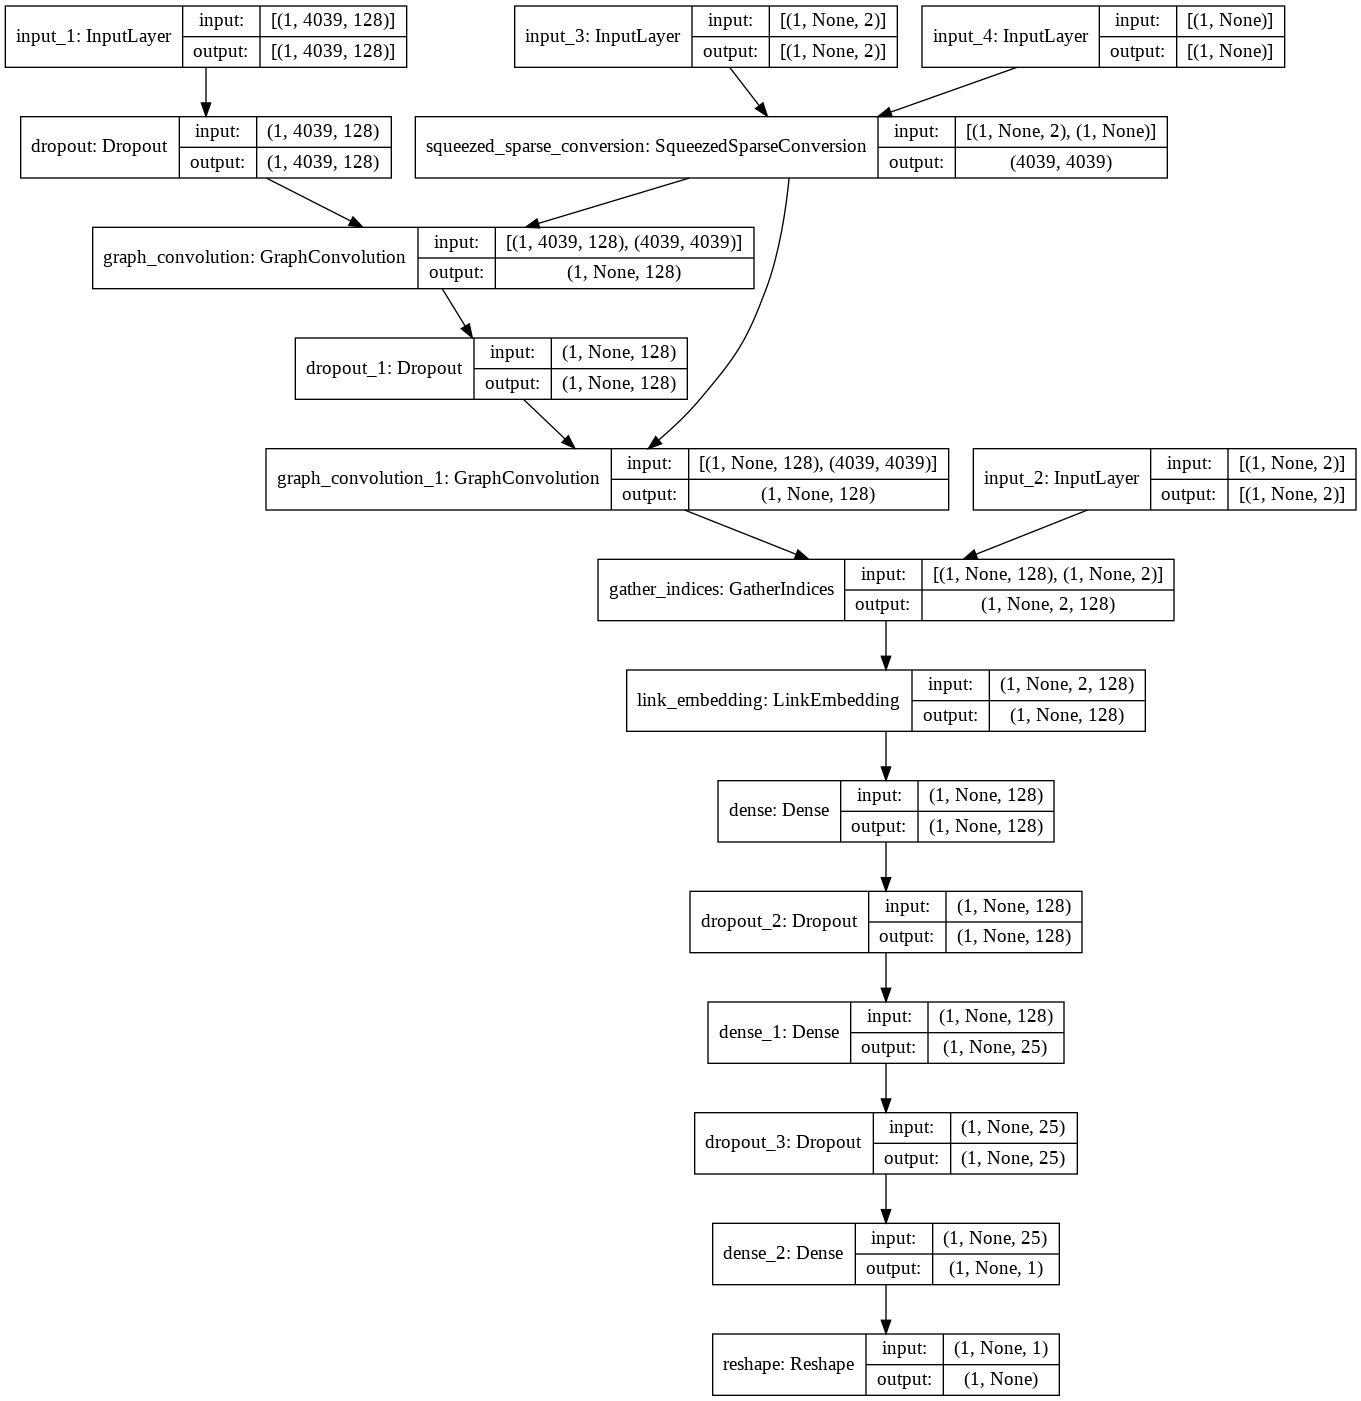

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 48ms/step - loss: 7.3047 - mae: 2.4746

Train Set Metrics of the initial (untrained) model:
	loss: 7.5617
	mae: 2.5213

Test Set Metrics of the initial (untrained) model:
	loss: 7.3047
	mae: 2.4746


Train the model:

In [25]:
from keras.callbacks import LambdaCallback,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_mae', mode='min', verbose=1)

history = model.fit(
    train_flow, epochs=5000, callbacks=[mcp_save],validation_data=test_flow, verbose=2, shuffle=False
)

Streaming output truncated to the last 5000 lines.
Epoch 3751/5000
1/1 - 0s - loss: 0.1914 - mae: 0.3374 - val_loss: 0.0716 - val_mae: 0.2078

Epoch 03751: val_mae did not improve from 0.18500
Epoch 3752/5000
1/1 - 0s - loss: 0.1876 - mae: 0.3357 - val_loss: 0.0662 - val_mae: 0.1892

Epoch 03752: val_mae did not improve from 0.18500
Epoch 3753/5000
1/1 - 0s - loss: 0.1864 - mae: 0.3305 - val_loss: 0.0719 - val_mae: 0.2079

Epoch 03753: val_mae did not improve from 0.18500
Epoch 3754/5000
1/1 - 0s - loss: 0.1906 - mae: 0.3405 - val_loss: 0.0708 - val_mae: 0.1995

Epoch 03754: val_mae did not improve from 0.18500
Epoch 3755/5000
1/1 - 0s - loss: 0.1895 - mae: 0.3330 - val_loss: 0.0727 - val_mae: 0.2147

Epoch 03755: val_mae did not improve from 0.18500
Epoch 3756/5000
1/1 - 0s - loss: 0.1857 - mae: 0.3327 - val_loss: 0.0664 - val_mae: 0.1911

Epoch 03756: val_mae did not improve from 0.18500
Epoch 3757/5000
1/1 - 0s - loss: 0.1806 - mae: 0.3256 - val_loss: 0.0696 - val_mae: 0.2066

Epoch

In [26]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.1)

In [27]:
model.load_weights("mdl_wts.hdf5")

Plot the training history:

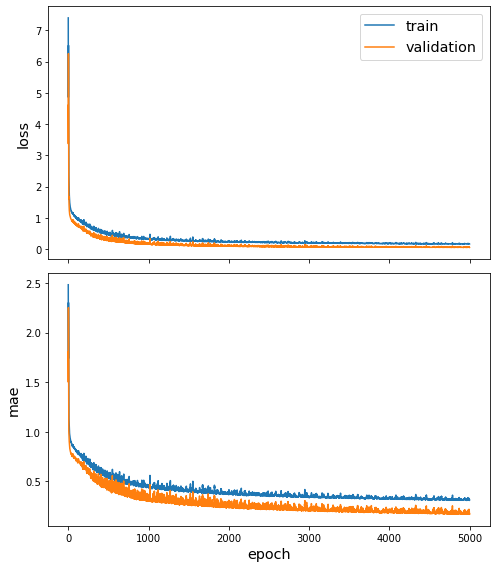

In [28]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [29]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 56ms/step - loss: 0.0558 - mae: 0.1666

Train Set Metrics of the trained model:
	loss: 0.0505
	mae: 0.1591

Test Set Metrics of the trained model:
	loss: 0.0558
	mae: 0.1666
